In [ ]:
import numpy as np
import cv2
import os ##TODO: delete
import matplotlib.pyplot as plt  ##TODO: delete

In [ ]:
output_path = os.path.join(os.path.expanduser('~'), "Desktop", "output")
image = cv2.imread(os.path.join(output_path, f'frame_1.png'))

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(image[:50, :100])

In [ ]:
class ImageCrop:
    def __init__(self):
        self.image = None
        self.i_x = None
        self.i_y = None
        self.x_c = None
        self.y_c = None
        self.width = None
        self.height = None

In [75]:
def split_image(image: np.ndarray, n_split_w: int, n_split_h: int, overlap_w: float = 0.1, overlap_h: float = 0.15) -> list[ImageCrop]:
    '''Takes an image (numpy array format) and splits it in n_split_w images along the width and  n_split_h images along the height.
    The overlap factors define how the cropped images overlap alogn both axis.   
    Returns a list of ImageCrop class object containing:
    -- image: the image it self (numpy array)
    -- i_x: i-th split along the x axis
    -- i_y: i-th split along the y axis
    -- x_c: upper_left x coordinate of the cropped image
    -- y_c: upper_left y coordinate of the cropped image
    -- width: width of the image
    -- height: height of the image
    '''
    assert type(image) == np.ndarray, 'The image inserted is not a numpy array'
    
    img_height, img_width, _ = image.shape
    
    crop_height = img_height // n_split_h + 1
    crop_width = img_width // n_split_w + 1
    
    overlap_height = int(overlap_h * img_height)
    overlap_width = int(overlap_w * img_width)
        
    if overlap_width > crop_width or overlap_height > crop_height:
        raise Exception("Overlap larger than the cropped areas themselves")

    crops = []
    
    for i_y in range(n_split_h):
        for i_x in range(n_split_w):
            crop = ImageCrop()
            crop.i_x = i_x
            crop.i_y = i_y
            
            # Defining coordinates along the Y axis
            if i_y == 0:
                y_c = i_y * crop_height
                height = crop_height + overlap_height
            elif i_y == n_split_h - 1:
                y_c = i_y * crop_height - overlap_height
                height = overlap_height + crop_height
            else:
                y_c = i_y * crop_height - overlap_height
                height = overlap_height + crop_height + overlap_height
            
            # Defining coordinates along the X axis
            if i_x == 0:
                x_c = i_x * crop_width
                width = crop_width + overlap_width
            elif i_x == n_split_w - 1:
                x_c = i_x * crop_width - overlap_width
                width = overlap_width + crop_width
            else:
                x_c = i_x * crop_width - overlap_width
                width = overlap_width + crop_width + overlap_width
            
            #Cropping the resulting image
            crop.image = image[y_c : y_c + height, x_c : x_c + width]
            crop.y_c = y_c
            crop.height = height
            crop.x_c = x_c
            crop.width = width
            
            crops.append(crop)
    
    return crops

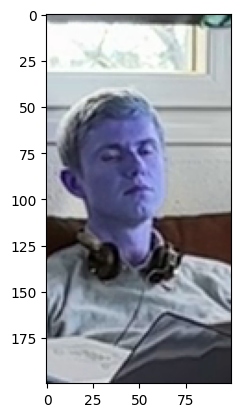

In [76]:
plt.imshow(image)

In [153]:
def reconstruct_coord(img_crop: ImageCrop, coord_set: list[dict]) -> list[dict]:
    '''Takes the list of the bbox coordinates detected on a cropped image and 
    returns the same list of bbox coordinates under the original image coordinate system'''
    coord_set_origin = []
    for coord in coord_set:
        coord_origin = dict()
        coord_origin['x1'] = coord['x1'] + img_crop.x_c
        coord_origin['x2'] = coord['x2'] + img_crop.x_c
        coord_origin['y1'] = coord['y1'] + img_crop.y_c
        coord_origin['y2'] = coord['y2'] + img_crop.y_c
        
        coord_set_origin.append(coord_origin)
    
    return coord_set_origin

In [240]:
def is_included_bbox(coord_bbox: dict, bbox_list: list[dict], intersect_threshold: float = 0.7) -> list[dict]:
    '''Checks if a bbox is designating the same person as the other bboxes in the list
    under the condition that the area of their intersect is above x% of either image area 
    '''
    area_bbox = (coord_bbox['x2'] - coord_bbox['x1']) * (coord_bbox['y2'] - coord_bbox['y1'])
    
    for coord_bbox_base in bbox_list:
        #Claculating area of the bboxes
        area_bbox_base = (coord_bbox_base['x2'] - coord_bbox_base['x1']) * (coord_bbox_base['y2'] - coord_bbox_base['y1'])
    
        #Calculating area of intersect
        intersect_width = min(coord_bbox['x2'], coord_bbox_base['x2']) - max(coord_bbox['x1'], coord_bbox_base['x1'])
        intersect_height = min(coord_bbox['y2'], coord_bbox_base['y2']) - max(coord_bbox['y1'], coord_bbox_base['y1'])
        area_intersect =  intersect_width * intersect_height if min(intersect_width, intersect_height) >0 else 0
    
        # Calculating the relative importance of the intersect vs. bboxes
        intersect_prop = area_intersect / min(area_bbox, area_bbox_base)

        if intersect_prop > intersect_threshold and area_bbox < area_bbox_base:
            return True
    
    return False

In [241]:
def bbox_merge(bbox_crop_list: list[list[dict]], intersect_threshold: float = 0.7) -> list[dict]:
    '''Takes the list of all bboxes coordinates across all cropped images and 
    returns a unified list of bbox coordinates under the original image coordinate system.
    Also eliminates overlapping bboxes from different crops (unique face) 
    '''
    # Concatenating the bboxes from different crops to one unified list of bboxes
    bbox_list = [coord_bbox for coord_set in bbox_crop_list for coord_bbox in coord_set]
    
    # Eliminating duplicates - ##TODO: might find a smarter way to do it
    bbox_list_output = []
    for i in range(len(bbox_list)):
        if not is_included_bbox(bbox_list[i], bbox_list[i+1:]) and not is_included_bbox(bbox_list[i], bbox_list_output):
            bbox_list_output.append(bbox_list[i])
    
    return bbox_list_output